# Analisis of Runs 3 and 4
## Calculate individual current as a function of time for different tilt angles.

This notebook takes the raw data from runs 3 and 4 and produces the dataset 

    /media/Antonio/Dynamic/DimerCurrents/Processed/23_08_01_Script10_currents.hdf
    
This notebook takes about 150 minutes in a single core

In [1]:
import sys
import os
sys.path.insert(0, '../magcolloids')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML, clear_output
import scipy.optimize as spo
import scipy.spatial as spa 
import magcolloids as mgc
import matplotlib as mpl
import string as st
import support as sp

from tqdm.auto import tqdm

ureg = mgc.ureg

idx = pd.IndexSlice

%reload_ext autoreload
%autoreload 2

In [2]:
directories = dict(odd = "/media/Antonio/Dynamic/DimerCurrents/Run3-PlainRun-Stat",
                  even = "/media/Antonio/Dynamic/DimerCurrents/Run4-OddRun-Stat")

In [3]:
directories

{'odd': '/media/Antonio/Dynamic/DimerCurrents/Run3-PlainRun-Stat',
 'even': '/media/Antonio/Dynamic/DimerCurrents/Run4-OddRun-Stat'}

This structure below creates a superindex from the indices of both datasets. 

In [4]:
index = {key:pd.read_csv(
    os.path.join(directories[key],"index.dat"), 
    names = ["file", "height", "tilt","seed","max_frame"], sep=" ") for key in directories}

index = pd.concat(index)

index["parity"] = index.index.get_level_values(0)
index["fid_origin"] = index.index.get_level_values(1)

index.index = pd.Index(range(len(index)))

index = index.query("max_frame!=0")

In [5]:
index.head()

,file,height,tilt,seed,max_frame,parity,fid_origin
0,Tilt_1_sd_34196_deg_h3899_2023_08_15_15_10_13,3.9,1,34196,1799926,odd,0
1,Tilt_0_sd_34200_deg_h3899_2023_08_15_15_10_13,3.9,0,34200,1799926,odd,1
2,Tilt_0_sd_34197_deg_h3899_2023_08_15_15_10_13,3.9,0,34197,1799926,odd,2
3,Tilt_0_sd_34194_deg_h3899_2023_08_15_15_10_13,3.9,0,34194,1799926,odd,3
4,Tilt_0_sd_34195_deg_h3899_2023_08_15_15_10_13,3.9,0,34195,1799926,odd,4


In [6]:
len(index)

600

## Development: Calculate the current from a sample trayectory

In [7]:
%%time
entry = index.query("tilt == 9").iloc[0]

location = os.path.join(directories[entry.parity], entry.file+".lammpstrj")

trj_read = mgc.trj_lazyread(location, 
                     output = ["x","y","z"])
trj = trj_read[:]
bounds = trj_read.get_bounds()

timestep = 1e-4
trj["time"] = trj.index.get_level_values("frame")*timestep

trj = trj.filter(["time", "x","y","z"])

CPU times: user 27.5 s, sys: 2.47 s, total: 30 s
Wall time: 2min 19s


In [8]:
trj.head()

time          x          y         z
frame id                                      
0     1    0.0 -28.963200 -30.360701  0.561224
      2    0.0 -31.590700 -30.360701 -0.561224
      3    0.0 -22.589100 -30.360701  0.561224
      4    0.0 -25.216600 -30.360701 -0.561224
      5    0.0 -16.215099 -30.360701  0.561224

In [9]:
vels = sp.calculate_velocities(trj, bounds.loc[[0]])

trj = trj.join(vels.filter(["x", "y", "z"]), how="right", rsuffix = "_v")

trj.head()

time          x          y         z  x_v  y_v  z_v
frame id                                                     
0     1    0.0 -28.963200 -30.360701  0.561224  NaN  NaN  NaN
      2    0.0 -31.590700 -30.360701 -0.561224  NaN  NaN  NaN
      3    0.0 -22.589100 -30.360701  0.561224  NaN  NaN  NaN
      4    0.0 -25.216600 -30.360701 -0.561224  NaN  NaN  NaN
      5    0.0 -16.215099 -30.360701  0.561224  NaN  NaN  NaN

In [10]:
trj["I_x"] = trj.eval("y_v * z / abs(z)")
trj["I_y"] = -trj.eval("x_v * z / abs(z)")

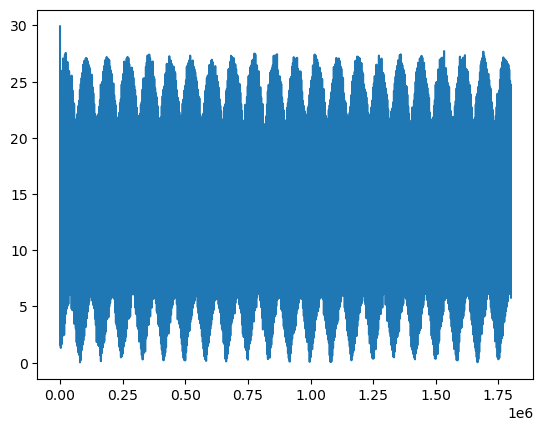

In [11]:
plt.plot(trj.groupby("frame").mean().eval("sqrt(I_x**2+I_y**2)"))

In [12]:
trj.head()

time          x          y         z  x_v  y_v  z_v  I_x  I_y
frame id                                                               
0     1    0.0 -28.963200 -30.360701  0.561224  NaN  NaN  NaN  NaN  NaN
      2    0.0 -31.590700 -30.360701 -0.561224  NaN  NaN  NaN  NaN  NaN
      3    0.0 -22.589100 -30.360701  0.561224  NaN  NaN  NaN  NaN  NaN
      4    0.0 -25.216600 -30.360701 -0.561224  NaN  NaN  NaN  NaN  NaN
      5    0.0 -16.215099 -30.360701  0.561224  NaN  NaN  NaN  NaN  NaN

### Let's wrap everything in a function to run it as a batch
We can use this to save to all the currents to a file

In [13]:
def calculate_currents(entry):

    # Read entry from .lammpstrj
    location = os.path.join(directories[entry.parity], entry.file+".lammpstrj")
    trj_read = mgc.trj_lazyread(location, 
                         output = ["x","y","z"])
    trj = trj_read[:]
    bounds = trj_read.get_bounds()

    ## add time column.
    timestep = 1e-4
    trj["time"] = trj.index.get_level_values("frame")*timestep
    trj = trj.filter(["time", "x","y","z"])
    
    ## Calculate velocities
    
    vels = sp.calculate_velocities(trj, bounds.loc[[0]])
    trj = trj.join(vels.filter(["x", "y", "z"]), how="right", rsuffix = "_v")
    
    ## Calculate Currents
    trj["I_x"] = trj.eval("y_v * z / abs(z)")
    trj["I_y"] = -trj.eval("x_v * z / abs(z)")
    trj["I"] = trj.eval("sqrt(I_x**2+I_y**2)")
    
    return trj, bounds

In [14]:
%%time 
trj, bnd = calculate_currents(entry)
trj.head()

CPU times: user 29.9 s, sys: 2.33 s, total: 32.2 s
Wall time: 2min 21s


time          x          y         z  x_v  y_v  z_v  I_x  I_y   I
frame id                                                                   
0     1    0.0 -28.963200 -30.360701  0.561224  NaN  NaN  NaN  NaN  NaN NaN
      2    0.0 -31.590700 -30.360701 -0.561224  NaN  NaN  NaN  NaN  NaN NaN
      3    0.0 -22.589100 -30.360701  0.561224  NaN  NaN  NaN  NaN  NaN NaN
      4    0.0 -25.216600 -30.360701 -0.561224  NaN  NaN  NaN  NaN  NaN NaN
      5    0.0 -16.215099 -30.360701  0.561224  NaN  NaN  NaN  NaN  NaN NaN

## Run Analisis: Save everything to a single hdf file

    /media/Antonio/Dynamic/DimerCurrents/Processed/23_08_01_Script10_currents.hdf


In [15]:
len(index)

600

In [16]:
trj

time          x          y         z        x_v       y_v  \
frame   id                                                                   
0       1      0.0000 -28.963200 -30.360701  0.561224        NaN       NaN   
        2      0.0000 -31.590700 -30.360701 -0.561224        NaN       NaN   
        3      0.0000 -22.589100 -30.360701  0.561224        NaN       NaN   
        4      0.0000 -25.216600 -30.360701 -0.561224        NaN       NaN   
        5      0.0000 -16.215099 -30.360701  0.561224        NaN       NaN   
...               ...        ...        ...       ...        ...       ...   
1799926 236  179.9926  17.403299  -4.307710 -0.556032  11.239537 -2.664692   
        237  179.9926  23.951000  -1.902220  0.566681  -6.287398 -2.352692   
        238  179.9926  23.711000  -4.391850 -0.553298   3.586843 -1.813180   
        239  179.9926  30.623400  -1.957630  0.554817  -4.574896  3.555085   
        240  179.9926  30.321800  -4.447610 -0.568033   4.317346  2.244904   

                  z_v       I_x        I_y          I  
frame   id                                             
0       1         NaN       NaN        NaN        NaN  
        2         NaN       NaN        NaN        NaN  
        3         NaN       NaN        NaN        NaN  
        4         NaN       NaN        NaN        NaN  
        5         NaN       NaN        NaN        NaN  
...               ...       ...        ...        ...  
1799926 236  0.471437  2.664692  11.239537  11.551094  
        237  0.613835 -2.352692   6.287398   6.713161  
        238  0.125930  1.813180   3.586843   4.019088  
        239  0.033775  3.555085   4.574896   5.793816  
        240 -0.334550 -2.244904   4.317346   4.866115  

[2586960 rows x 10 columns]

In [ ]:
%%time

!mkdir /media/Antonio/Dynamic/DimerCurrents/Processed/
file = "/media/Antonio/Dynamic/DimerCurrents/Processed/23_08_01_Script10_currents.hdf"
index.to_hdf(file, mode = "w", key = "index")

subindex = index

for i,entry in tqdm(subindex.iterrows(), total = len(index)):
    trj, bnd = calculate_currents(entry)
    trj.to_hdf(file, mode = "a", key = entry.file)
    bnd.to_hdf(file, mode = "a", key = "bounds/"+entry.file)

mkdir: cannot create directory ‘/media/Antonio/Dynamic/DimerCurrents/Processed/’: File exists


  0%|          | 0/600 [00:00<?, ?it/s]

In [ ]:
index = pd.read_hdf(file, key = "index")

aggregate = []

for i,entry in tqdm(subindex.iterrows(), total = len(index)):
    trj = pd.read_hdf(file, key = entry.file)
    timeseries = trj.groupby("time").I_x.mean().to_frame("I_x")
    timeseries["I_y"] = trj.groupby("time").I_y.mean()
    timeseries["var_x"] = trj.groupby("time").I_x.var()
    timeseries["var_y"] = trj.groupby("time").I_y.var()
    timeseries["N"] = trj.groupby("time").I.count()
    
    aggregate.append(timeseries)
    
aggregate = pd.concat(aggregate, 
      keys = list(subindex.filter(["tilt","parity","seed"]).itertuples(index=False)),
      names = ["tilt","parity","seed"])

In [ ]:
directory = "/media/Antonio/Dynamic/DimerCurrents/Processed/"
aggregate.to_hdf(os.path.join(directory,"23_08_01_Script10_currents_vs_time.hdf"),
                 mode="w", key = "current_vs_time")